In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
project_name = 'CAT-dcgan'

In [3]:
DATA_DIR = '../input/cats-faces-64x64-for-generative-models/'

In [4]:
print(os.listdir(DATA_DIR))

['cats']


In [5]:
print(os.listdir(DATA_DIR+'/cats')[:10])

['8099.jpg', '13782.jpg', '11484.jpg', '958.jpg', '1684.jpg', '11357.jpg', '1153.jpg', '4886.jpg', '5661.jpg', '14054.jpg']


In [6]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [7]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [8]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [9]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [10]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

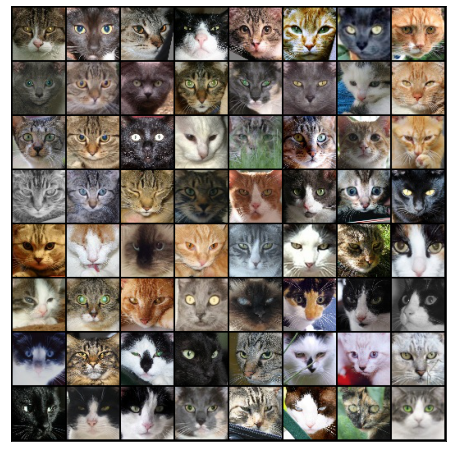

In [11]:
show_batch(train_dl)

In [11]:
!pip install jovian --upgrade --quiet

In [12]:
import jovian

<IPython.core.display.Javascript object>

In [38]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/shubham7169007/CAT-dcgan


<IPython.core.display.Javascript object>

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = get_default_device()
device

device(type='cuda')

In [15]:
train_dl = DeviceDataLoader(train_dl, device)

In [16]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [17]:
discriminator = to_device(discriminator, device)

In [18]:
latent_size = 128

In [19]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


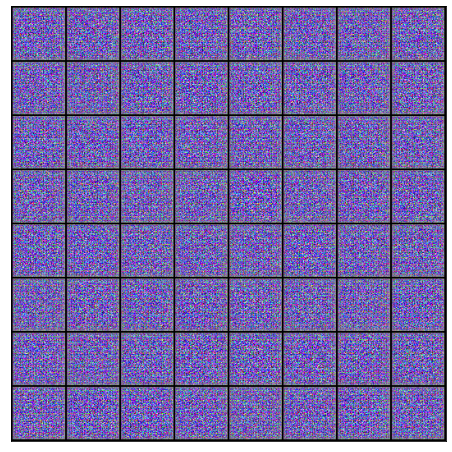

In [20]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [21]:
generator = to_device(generator, device)

In [22]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [23]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [24]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [25]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [26]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


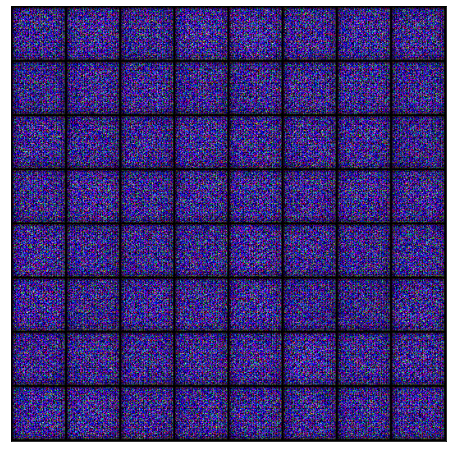

In [27]:
save_samples(0, fixed_latent)

In [28]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [29]:
lr = 0.0002
epochs = 60

In [30]:
history = fit(epochs, lr)


Epoch [1/60], loss_g: 5.9449, loss_d: 0.7790, real_score: 0.8575, fake_score: 0.4179
Saving generated-images-0001.png



Epoch [2/60], loss_g: 4.8628, loss_d: 0.2609, real_score: 0.9367, fake_score: 0.1655
Saving generated-images-0002.png



Epoch [3/60], loss_g: 1.4402, loss_d: 0.9564, real_score: 0.5297, fake_score: 0.1182
Saving generated-images-0003.png



Epoch [4/60], loss_g: 5.4418, loss_d: 1.1722, real_score: 0.8261, fake_score: 0.5676
Saving generated-images-0004.png



Epoch [5/60], loss_g: 5.0835, loss_d: 0.1886, real_score: 0.9429, fake_score: 0.1145
Saving generated-images-0005.png



Epoch [6/60], loss_g: 3.2533, loss_d: 0.4667, real_score: 0.8079, fake_score: 0.2029
Saving generated-images-0006.png



Epoch [7/60], loss_g: 1.5616, loss_d: 0.7558, real_score: 0.6130, fake_score: 0.1635
Saving generated-images-0007.png



Epoch [8/60], loss_g: 3.5968, loss_d: 0.3991, real_score: 0.8444, fake_score: 0.1736
Saving generated-images-0008.png



Epoch [9/60], loss_g: 4.4417, loss_d: 0.2475, real_score: 0.9193, fake_score: 0.1361
Saving generated-images-0009.png



Epoch [10/60], loss_g: 7.0182, loss_d: 0.4998, real_score: 0.9931, fake_score: 0.3561
Saving generated-images-0010.png



Epoch [11/60], loss_g: 5.6128, loss_d: 0.5728, real_score: 0.9905, fake_score: 0.3876
Saving generated-images-0011.png



Epoch [12/60], loss_g: 4.2682, loss_d: 0.0967, real_score: 0.9584, fake_score: 0.0509
Saving generated-images-0012.png



Epoch [13/60], loss_g: 3.4293, loss_d: 0.2392, real_score: 0.9590, fake_score: 0.1717
Saving generated-images-0013.png



Epoch [14/60], loss_g: 2.9661, loss_d: 0.3959, real_score: 0.7310, fake_score: 0.0227
Saving generated-images-0014.png



Epoch [15/60], loss_g: 4.3064, loss_d: 0.0820, real_score: 0.9825, fake_score: 0.0605
Saving generated-images-0015.png



Epoch [16/60], loss_g: 4.5196, loss_d: 1.5263, real_score: 0.3193, fake_score: 0.0012
Saving generated-images-0016.png



Epoch [17/60], loss_g: 4.8861, loss_d: 0.0938, real_score: 0.9803, fake_score: 0.0682
Saving generated-images-0017.png



Epoch [18/60], loss_g: 6.8235, loss_d: 0.1477, real_score: 0.8666, fake_score: 0.0015
Saving generated-images-0018.png



Epoch [19/60], loss_g: 5.1378, loss_d: 0.1653, real_score: 0.8614, fake_score: 0.0118
Saving generated-images-0019.png



Epoch [20/60], loss_g: 5.2367, loss_d: 0.3041, real_score: 0.9015, fake_score: 0.1611
Saving generated-images-0020.png



Epoch [21/60], loss_g: 11.5192, loss_d: 0.5098, real_score: 0.9876, fake_score: 0.3516
Saving generated-images-0021.png



Epoch [22/60], loss_g: 4.3907, loss_d: 0.0621, real_score: 0.9880, fake_score: 0.0448
Saving generated-images-0022.png



Epoch [23/60], loss_g: 6.7981, loss_d: 0.1685, real_score: 0.9916, fake_score: 0.1336
Saving generated-images-0023.png



Epoch [24/60], loss_g: 7.1687, loss_d: 0.5331, real_score: 0.8617, fake_score: 0.2593
Saving generated-images-0024.png



Epoch [25/60], loss_g: 0.3113, loss_d: 2.5081, real_score: 0.2058, fake_score: 0.0033
Saving generated-images-0025.png



Epoch [26/60], loss_g: 5.1444, loss_d: 0.0340, real_score: 0.9973, fake_score: 0.0299
Saving generated-images-0026.png



Epoch [27/60], loss_g: 2.8560, loss_d: 0.4521, real_score: 0.6961, fake_score: 0.0185
Saving generated-images-0027.png



Epoch [28/60], loss_g: 5.4598, loss_d: 0.0327, real_score: 0.9994, fake_score: 0.0306
Saving generated-images-0028.png



Epoch [29/60], loss_g: 0.3006, loss_d: 1.0065, real_score: 0.4291, fake_score: 0.0127
Saving generated-images-0029.png



Epoch [30/60], loss_g: 5.4145, loss_d: 0.2533, real_score: 0.8013, fake_score: 0.0089
Saving generated-images-0030.png



Epoch [31/60], loss_g: 2.1738, loss_d: 1.5501, real_score: 0.3033, fake_score: 0.0011
Saving generated-images-0031.png



Epoch [32/60], loss_g: 6.1654, loss_d: 0.1154, real_score: 0.8967, fake_score: 0.0012
Saving generated-images-0032.png



Epoch [33/60], loss_g: 11.9276, loss_d: 0.0333, real_score: 0.9677, fake_score: 0.0001
Saving generated-images-0033.png



Epoch [34/60], loss_g: 1.4495, loss_d: 0.8134, real_score: 0.5574, fake_score: 0.0042
Saving generated-images-0034.png



Epoch [35/60], loss_g: 9.9948, loss_d: 0.8493, real_score: 0.9988, fake_score: 0.4737
Saving generated-images-0035.png



Epoch [36/60], loss_g: 1.7796, loss_d: 0.5690, real_score: 0.6158, fake_score: 0.0010
Saving generated-images-0036.png



Epoch [37/60], loss_g: 5.5247, loss_d: 0.2181, real_score: 0.8227, fake_score: 0.0027
Saving generated-images-0037.png



Epoch [38/60], loss_g: 4.3593, loss_d: 0.1181, real_score: 0.9099, fake_score: 0.0196
Saving generated-images-0038.png



Epoch [39/60], loss_g: 9.2116, loss_d: 0.1548, real_score: 0.8592, fake_score: 0.0002
Saving generated-images-0039.png



Epoch [40/60], loss_g: 10.9030, loss_d: 0.9792, real_score: 0.9332, fake_score: 0.5048
Saving generated-images-0040.png



Epoch [41/60], loss_g: 6.2918, loss_d: 0.1665, real_score: 0.9954, fake_score: 0.1328
Saving generated-images-0041.png



Epoch [42/60], loss_g: 8.4345, loss_d: 0.0100, real_score: 0.9938, fake_score: 0.0038
Saving generated-images-0042.png



Epoch [43/60], loss_g: 5.7516, loss_d: 0.8090, real_score: 0.5886, fake_score: 0.0006
Saving generated-images-0043.png



Epoch [44/60], loss_g: 2.5483, loss_d: 0.2700, real_score: 0.8124, fake_score: 0.0193
Saving generated-images-0044.png



Epoch [45/60], loss_g: 5.8426, loss_d: 0.0596, real_score: 0.9655, fake_score: 0.0226
Saving generated-images-0045.png



Epoch [46/60], loss_g: 4.9898, loss_d: 0.0996, real_score: 0.9193, fake_score: 0.0118
Saving generated-images-0046.png



Epoch [47/60], loss_g: 7.4141, loss_d: 0.0462, real_score: 0.9567, fake_score: 0.0013
Saving generated-images-0047.png



Epoch [48/60], loss_g: 2.4418, loss_d: 0.4503, real_score: 0.7014, fake_score: 0.0127
Saving generated-images-0048.png



Epoch [49/60], loss_g: 5.8999, loss_d: 0.2118, real_score: 0.9908, fake_score: 0.1527
Saving generated-images-0049.png



Epoch [50/60], loss_g: 7.3262, loss_d: 0.1244, real_score: 0.8886, fake_score: 0.0004
Saving generated-images-0050.png



Epoch [51/60], loss_g: 3.2233, loss_d: 0.2886, real_score: 0.8511, fake_score: 0.0974
Saving generated-images-0051.png



Epoch [52/60], loss_g: 9.0477, loss_d: 0.4428, real_score: 0.9154, fake_score: 0.2457
Saving generated-images-0052.png



Epoch [53/60], loss_g: 3.8481, loss_d: 0.3505, real_score: 0.7189, fake_score: 0.0023
Saving generated-images-0053.png



Epoch [54/60], loss_g: 5.8651, loss_d: 0.0174, real_score: 0.9889, fake_score: 0.0059
Saving generated-images-0054.png



Epoch [55/60], loss_g: 8.8639, loss_d: 0.3561, real_score: 0.9975, fake_score: 0.2622
Saving generated-images-0055.png



Epoch [56/60], loss_g: 3.8313, loss_d: 0.2000, real_score: 0.8608, fake_score: 0.0311
Saving generated-images-0056.png



Epoch [57/60], loss_g: 6.2153, loss_d: 0.1091, real_score: 0.9984, fake_score: 0.0773
Saving generated-images-0057.png



Epoch [58/60], loss_g: 2.1912, loss_d: 0.5770, real_score: 0.7099, fake_score: 0.0228
Saving generated-images-0058.png



Epoch [59/60], loss_g: 5.0010, loss_d: 0.0857, real_score: 0.9512, fake_score: 0.0321
Saving generated-images-0059.png



Epoch [60/60], loss_g: 5.8587, loss_d: 0.0268, real_score: 0.9781, fake_score: 0.0043
Saving generated-images-0060.png


In [31]:
losses_g, losses_d, real_scores, fake_scores = history

In [32]:
from IPython.display import Image

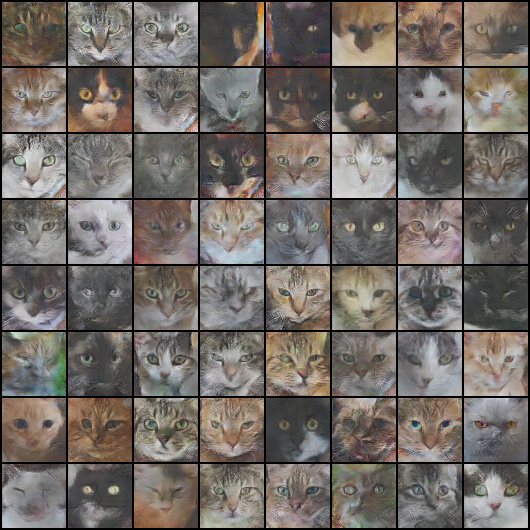

In [33]:
Image('./generated/generated-images-0060.png')

In [34]:
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

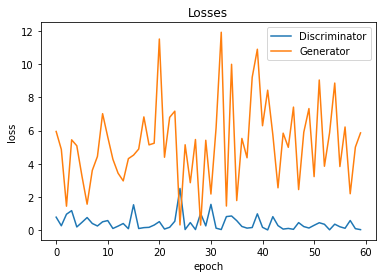

In [35]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

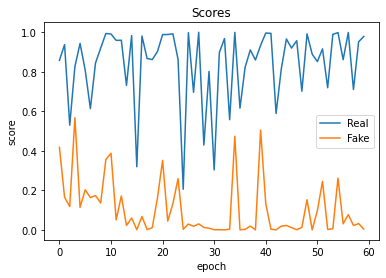

In [36]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');